In [540]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [541]:
def preprocessing(df, type1):
    features  = df.drop(['Creditworthy'], axis = 1)
    features.replace(to_replace = '?', value = np.nan, inplace = True)

    if type1:
        one_hot_columns = ['Status_of_EA', 'Credit_hist', 'Purpose', 'Savings_account', 'Personal_status', 
                               'Other_debtors', 'Property', 'Other_IP', 'Housing', 'Job', 'Telephone', 'Foreign_worker']

        #One-hot encoding of all categorical columns except Present_ES (Present employment since)
        features_oneHot  = pd.get_dummies(features, dummy_na=True, columns=one_hot_columns)

        #Drop all constant columns
        features_oneHot  = features_oneHot.loc[:, (features_oneHot != features_oneHot.iloc[0]).any()]

        return features_oneHot 

    else:
        categorical_columns = ['Credit_hist', 'Purpose', 'Personal_status', 'Other_debtors', 'Property', 'Other_IP', 
                               'Housing', 'Job', 'Telephone', 'Foreign_worker']

        #One-hot encoding of all categorical columns except Present_ES (Present employment since)
        features_oneHot  = pd.get_dummies(features, dummy_na=True, columns=categorical_columns)

        #Drop all constant columns
        features_oneHot  = features_oneHot.loc[:, (features_oneHot != features_oneHot.iloc[0]).any()]

        #Here I use a numerical transformation for the two numerical continuous features in our data 
        #(Status of existing checking account and Savings account/bonds)
        
        #Status of existing checking account
        checkAcc = [-100, 100, 300, 0]

        #Savings account/bonds
        savingAccount = [50, 250, 750, 1250, 0]

        for i in range(4):
            features_oneHot.Status_of_EA.replace(to_replace = 'A1'+str(i+1), value = checkAcc[i], inplace=True)
        
        for j in range(5):
            features_oneHot.Savings_account.replace(to_replace = 'A6'+str(j+1), value = savingAccount[i], inplace=True)

        return features_oneHot 

def decisionTreeReg(X_train, X_test, y_train, y_test):
    
    #DescisionTreeRegressor with MSE splitting criterion
    reg = DecisionTreeRegressor(criterion = 'mse')
    #I vary min_samples_split and max_leaf_nodes parameters of the tree and search 
    #for the best estimator optimized by a cross validation
    params = {'min_samples_split' : range(5, 50), 'max_leaf_nodes' : range(5, 15)}

    grid_search_cv = GridSearchCV(reg, params, cv=5)
    grid_search_cv.fit(X_train, y_train)

    best_est   = grid_search_cv.best_estimator_
    print("Best parameters of DecisionTreeRegressor", grid_search_cv.best_params_)
    y_pred = best_est.predict(X_test)
    err    = mean_squared_error(y_test, y_pred)
    
    return best_est, err 

def linReg(X_train, X_test, y_train, y_test):

    reg         = LinearRegression().fit(X_train, y_train)
    predictions = reg.predict(X_test)
    err = mean_squared_error(y_test, predictions)

    return reg, err

def feature_importance(model, X_train, y_train, n_repeats):
    #Use permutation importance with 10 repeats on all features of the train dataset  
    perm_import = permutation_importance(model, X_train, y_train, n_repeats=n_repeats, random_state=0)
    #Find mean permutation importance of 10 repeats
    perm_mean   = perm_import.importances_mean

    return perm_mean

def predictPresentES(preprocessed):
    expYears = [0, 0.5, 2.5, 5.5, 9]

    #Numerical representation of "Present employment since" feature that I am going to predict
    for i in range(5):
        preprocessed.Present_ES.replace(to_replace = 'A7'+str(i+1), value = expYears[i], inplace=True)

    #Split data set on a dataset where are no missing values in present employment since feature and on a data set,
    #where all Prese_ES features are missed 
    withPES          = preprocessed.loc[preprocessed['Present_ES'].notnull()]
    missingPES       = preprocessed.loc[preprocessed['Present_ES'].isnull()]

    #X - all samples with present values of Present_ES without Present_ES column, that will be used as labels
    X      = withPES.drop(['Present_ES'], axis = 1)  
    #data - features with missing values of Present_ES, that will be used for predictions  
    data   = missingPES.drop(['Present_ES'], axis = 1)

    #labels of Present_ES
    y = withPES.Present_ES

    #split X and y on train and test data set, to validate the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Try with decision Tree regressor
    best_tree, tree_mse = decisionTreeReg(X_train, X_test, y_train, y_test) 
    print("MSE DecisionTreeRegressor", tree_mse)

    #plot best decision tree
    fig, ax = plt.subplots(figsize=(19.2,10.8))
    plot_tree(best_tree, ax=ax, class_names=[str(i) for i in range(5)], feature_names=X_train.columns) 
    plt.show()

    #Try linear regression
    linearReg, mse_LinReg = linReg(X_train, X_test, y_train, y_test)
    print("MSE LinearRegression with all features", mse_LinReg)

    #Use permutation importance for linear regression model
    perm_mean = feature_importance(linearReg, X_train, y_train, 10)

    plt.figure(figsize=(12,8))
    plt.title('Feature importances', fontsize=20)
    perm_mean = np.array(perm_mean)
    idxSort = np.argsort(perm_mean)
    plt.plot(X_train.columns[np.flip(idxSort)[:10]], perm_mean[np.flip(idxSort)[:10]], 'bx')
    plt.xticks(X_train.columns[np.flip(idxSort)[:10]], X_train.columns[np.flip(idxSort)[:10]], fontsize=14, rotation='vertical', )
    plt.yticks(fontsize=14)
    plt.ylabel('Feature importances Preprocessing', fontsize=16)
    plt.show()

    mse_differentFI  = []
    models_differentFI = [] 
    columns_differentFI = []

    #Try to drop some features and find a best set of most important features
    #and make predictions only with theses set of features  
    for i in perm_mean[idxSort]:
  
        data_bestPermImp = X_train.iloc[:, np.where(perm_mean >= i)[0]]
        maxFI = data_bestPermImp.columns

        X_train_maxFI = X_train[maxFI]
        X_test_maxFI  = X_test[maxFI]

        LinReg_bestFI, mse_LinReg_bestFI = linReg(X_train_maxFI, X_test_maxFI, y_train, y_test)
        mse_differentFI.append(mse_LinReg_bestFI)
        models_differentFI.append(LinReg_bestFI)
        columns_differentFI.append(maxFI) 

    LinReg_bestFI = models_differentFI[np.argmin(np.array(mse_differentFI))] 
    mse_LinReg_bestFI = min(mse_differentFI)
    print("MSE of Linear Regression model with highest feature importances", mse_LinReg_bestFI)

    maxFI = columns_differentFI[np.argmin(np.array(mse_differentFI))]

    print("Shape of X_train with all features", X_train.shape)
    print("Shape of X_train with best features only", data[maxFI].shape) 

    minMSE = min([tree_mse, mse_LinReg, mse_LinReg_bestFI])
    

    if minMSE == tree_mse:
        print("Desicison Tree was used")
        predictionsPES = best_tree.predict(data)                
        preprocessed.loc[preprocessed.Present_ES.isnull(), 'Present_ES'] = predictionsPES 
        return preprocessed

    elif minMSE == mse_LinReg:
        print("Linear Regression with all features was used")
        predictionsPES = linearReg.predict(data)
        preprocessed.loc[preprocessed.Present_ES.isnull(), 'Present_ES'] = predictionsPES
        return preprocessed

    else:
        print("Linear Regression with most important features was used")
        data      = data[maxFI]
        predictionsPES  = LinReg_bestFI.predict(data)
        preprocessed.loc[preprocessed.Present_ES.isnull(), 'Present_ES'] = predictionsPES
        return preprocessed

def errorsType(y_test, predictions):
    #Array of different thresholds  
    thresholds = np.arange(0.1, 1, 0.01)

    fp = []
    fn = []

    for i in thresholds:
        #Predict class 1 if the predicted probability of class 1 is higher than threshold i
        predictOne  = predictions > i
        #Predict class 0 if the predicted probability of class 1 is less or equal threshold i
        predictZero = predictions <= i

        #Count number of False positives 
        fp.append(np.sum(predictOne & (y_test == 0)))
        #Count number of False negatives
        fn.append(np.sum(predictZero & (y_test == 1)))
    
    return thresholds, fp, fn

def best_threshold(fp, fn, thresholds): 

    #Cost function where false positives have 5 times higher importnace than false negatives
    costSensetiveLost = 5*np.array(fp) + np.array(fn)
    plt.figure(figsize=(12,8))
    plt.title('Best costSensetive threshold ' + str(round(thresholds[np.argmin(costSensetiveLost)], 2)), fontsize=20)
    plt.plot(np.array(thresholds), costSensetiveLost)
    plt.xlabel('Thresholds', fontsize=18)
    plt.ylabel('Weighted cost of FPs and FNs', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return thresholds[np.argmin(costSensetiveLost)]

def analyseAllPreprocTypes(data, labels, withFI):

    #Labels preprocessing. Since I am going to use logistic regression, that output is the probability of 
    #a class being 0 or 1, we need to represent the labels as 0 and 1
    labels = labels.replace(to_replace = 2, value = 0)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

    #if with FI find feature importances and use only most important features for training
    if withFI:

        model     = LogisticRegression().fit(X_train, y_train)
        perm_mean = feature_importance(model, X_train, y_train, 10)

        plt.figure(figsize=(12,8))
        plt.title('Feature importances', fontsize=20)
        perm_mean = np.array(perm_mean)
        idxSort = np.argsort(perm_mean)
        plt.plot(X_train.columns[np.flip(idxSort)[:22]], perm_mean[np.flip(idxSort)[:22]], 'bx')
        plt.xticks(X_train.columns[np.flip(idxSort)[:22]], X_train.columns[np.flip(idxSort)[:22]], rotation='vertical', fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel('Feature importances Logistic regression', fontsize=16)
        plt.show()

        bestPermImp = X_train.iloc[:, np.where(perm_mean > 0.0015)[0]]
        maxFI = bestPermImp.columns

        print("Shape of X_train with all features", X_train.shape)
        X_train = X_train[maxFI]
        print("Shape of X_train with most important features", X_train.shape)
        X_test  = X_test[maxFI]

    #Logistic regression model 
    logReg = LogisticRegression(max_iter=15000)
    #Try different regularization parameters C and find the best model 
    #validated by 5-fold cross valdation
    param_LogReg = {'C' : range(2, 16, 2)}

    grid_search_cv_logReg = GridSearchCV(logReg, param_LogReg, scoring='f1', cv=5)
    grid_search_cv_logReg.fit(X_train, y_train)

    best_logReg   = grid_search_cv_logReg.best_estimator_
    y_pred_default = best_logReg.predict(X_test)

    #Different validation metrics for predictions with default threshold 
    precisionDefault = precision_score(y_test, y_pred_default)
    recallDefault   = recall_score(y_test, y_pred_default)
    fpDefault       = np.sum((y_pred_default == 1) & (y_test == 0))
    fnDefault       = np.sum((y_pred_default == 0) & (y_test == 1))
    tpDefault       = np.sum((y_pred_default == 1) & (y_test == 1))
    tnDefault       = np.sum((y_pred_default == 0) & (y_test == 0))
    accuracyDefault = np.sum(y_pred_default == y_test)/len(y_test)
    costTresholdDefault = fpDefault*5 + fnDefault
    f1Default = f1_score(y_test, y_pred_default)

    metrics_default = pd.DataFrame({'Estimator' : ['Logistic Regression Default param'], 
                                    'Precision' : [precisionDefault],
                                    'Recall'    : [recallDefault],
                                    'Number FP' : [fpDefault],
                                    'Number FN' : [fnDefault],
                                    'Number TP' : [tpDefault],
                                    'Number TN' : [tnDefault],
                                    'Accuracy'  : [accuracyDefault],
                                    'Total cost with threshold' : [costTresholdDefault],
                                    'Threshold' : [0.5], 
                                    'F1 score' : [f1Default]})
    
    predict_probaLogReg = best_logReg.predict_proba(X_test)

    #predicted probabilities for class 1
    y_probaLogReg = predict_probaLogReg[:, 1]
 
    #The default classification threshold of binary classification is 0.5,
    #but since identifing of not creditworthy client as creditworthy is 5 times more expensive, than the other way around 
    #We need to find another threshold with a stricter rejection of false positives

    thresholdLogReg, fp, fn  = errorsType(y_test, y_probaLogReg)
    best_thresholdLogReg = round(best_threshold(fp, fn, thresholdLogReg), 2)

    y_pred_bestThreshold = np.where(y_probaLogReg > best_thresholdLogReg, 1, 0)
    
    metrics_differentThresholds  =  pd.DataFrame()

    minThreshold = best_thresholdLogReg - 0.1
    maxThreshold = best_thresholdLogReg + 0.1

    #Different validation metrics for predictions with different thresholds 
    for i in np.arange(minThreshold, maxThreshold, 0.01):
        y_pred_Diff_Thresholds = np.where(y_probaLogReg > i, 1, 0)
        precision = precision_score(y_test, y_pred_Diff_Thresholds)
        recall = recall_score(y_test, y_pred_Diff_Thresholds)
        f1 = f1_score(y_test, y_pred_Diff_Thresholds)
        fp = np.sum((y_pred_Diff_Thresholds == 1) & (y_test == 0))
        fn = np.sum((y_pred_Diff_Thresholds == 0) & (y_test == 1))
        tp = np.sum((y_pred_Diff_Thresholds == 1) & (y_test == 1))
        tn = np.sum((y_pred_Diff_Thresholds == 0) & (y_test == 0))
        accuracy = np.sum(y_pred_Diff_Thresholds == y_test)/len(y_test)
        cost_default  = metrics_default['Number FP'].loc[0]*5 + metrics_default['Number FN'].loc[0]
        cost_threshold = fp*5 + fn
        weightedFscore = tp / (tp + 0.5*(5*fp + fn))

        metrics =    pd.DataFrame({'Estimator' : ['Logistic Regression'], 
                                                  'Precision' : [precision],
                                                  'Recall'    : [recall],
                                                  'Number FP' : [fp],
                                                  'Number FN' : [fn],
                                                  'Number TP' : [tn],
                                                  'Number TN' : [tn],
                                                  'Accuracy'  : [accuracy],
                                                  'Total cost with current threshold' : [cost_threshold],
                                                  'Threshold' : [i], 
                                                  'F1 score' : [f1],
                                                  'Weighted F1 score' : [weightedFscore]})
        
        metrics_differentThresholds = metrics_differentThresholds.append(metrics)

    return best_logReg, y_probaLogReg, y_pred_bestThreshold, metrics_default, metrics_differentThresholds, y_test

def printROCcurve(y_test, y_proba, y_pred, metrics):
    
    #Roc curve for predicted probabilities
    fpr_default, tpr_default, threshold_default = roc_curve(y_test, y_proba)

    tn = np.sum((y_pred == 0) & (y_test == 0))

    metricsBestTreshold = metrics.loc[(metrics['Total cost with current threshold'] == metrics['Total cost with current threshold'].min())]

    #Find true positive rate and false positive rate with best threshold for our problem
    tpr_best = metricsBestTreshold['Recall'].loc[metricsBestTreshold['Accuracy'] == metricsBestTreshold['Accuracy'].max()] 
    fp_best = metricsBestTreshold['Number FP'].loc[metricsBestTreshold['Accuracy'] == metricsBestTreshold['Accuracy'].max()]

    fpr_best = fp_best / (fp_best + tn)

    plt.figure(figsize=(12,8))
    plt.title('ROC Curve', fontsize=20)
    plt.plot(fpr_default, tpr_default)
    plt.plot(fpr_best, tpr_best, marker = "x", c = 'black', linewidth=4, markersize=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=16)

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()      

In [542]:
#Load data set and set column names
df = pd.read_csv('kredit.dat', sep = '\t', header = None)
df.columns = ['Status_of_EA', 'Duration', 'Credit_hist', 'Purpose', 
              'Credit_amount', 'Savings_account', 'Present_ES', 
              'Installment_rate', 'Personal_status', 'Other_debtors', 
              'Present_RS', 'Property', 'Age', 'Other_IP', 'Housing', 
              'Num_exist_credits', 'Job', 'Number_of_people', 
              'Telephone', 'Foreign_worker', 'Creditworthy']

labels = df.Creditworthy
print("Labels initialy", np.array(labels[:5]))

Labels initialy [1 1 2 1 1]


In [543]:
#Initial data set
df.head()

,Status_of_EA,Duration,Credit_hist,Purpose,Credit_amount,Savings_account,Present_ES,Installment_rate,Personal_status,Other_debtors,Present_RS,Property,Age,Other_IP,Housing,Num_exist_credits,Job,Number_of_people,Telephone,Foreign_worker,Creditworthy
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201,1


In [544]:
#Data preprocessing. "Status of existing checking account" and "Savings account/bonds" features are one-hot encoded 
preprocessedData1 = preprocessing(df, True)

In [545]:
preprocessedData1.head()

,Duration,Credit_amount,Present_ES,Installment_rate,Present_RS,Age,Num_exist_credits,Number_of_people,Status_of_EA_A11,Status_of_EA_A12,Status_of_EA_A13,Status_of_EA_A14,Credit_hist_A30,Credit_hist_A31,Credit_hist_A32,Credit_hist_A33,Credit_hist_A34,Purpose_A40,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Purpose_nan,Savings_account_A61,Savings_account_A62,Savings_account_A63,Savings_account_A64,Savings_account_A65,Personal_status_A91,Personal_status_A92,Personal_status_A93,Personal_status_A94,Other_debtors_A101,Other_debtors_A102,Other_debtors_A103,Property_A121,Property_A122,Property_A123,Property_A124,Other_IP_A141,Other_IP_A142,Other_IP_A143,Housing_A151,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Job_nan,Telephone_A191,Telephone_A192,Foreign_worker_A201,Foreign_worker_A202,Foreign_worker_nan
0,36,2299,NaN,4,4,39,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
1,18,1239,A73,4,4,61,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0
2,24,947,A74,4,3,38,1,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
3,15,1478,A73,4,3,33,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
4,24,1525,A74,4,3,34,1,2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0


In [546]:
# Present employment since
# A71: unemployed
# A72: ... < 1 year
# A73: 1 ≤ ... < 4 years
# A74: 4 ≤ ... < 7 years
# A75: .. ≥ 7 years

#Count number of clients for different employment durations
preprocessedData1.Present_ES.value_counts()

A73    157
A75    133
A74     96
A72     85
A71     33
Name: Present_ES, dtype: int64

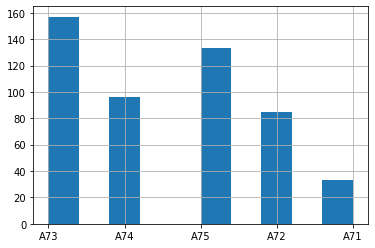

In [547]:
preprocessedData1.Present_ES.hist()

In [548]:
#Total number of clients
print(preprocessedData1.Present_ES.shape)

(1000,)


In [549]:
#Number of clients with missing values for "Present employment since feature"
preprocessedData1.Present_ES.isna().sum()

496

In [550]:
#Data preprocessing type 2. "Status of existing checking account" and "Savings account/bonds" features are represented with numerical values
preprocessedData2 = preprocessing(df, False)

In [551]:
preprocessedData2.head()

,Status_of_EA,Duration,Credit_amount,Savings_account,Present_ES,Installment_rate,Present_RS,Age,Num_exist_credits,Number_of_people,Credit_hist_A30,Credit_hist_A31,Credit_hist_A32,Credit_hist_A33,Credit_hist_A34,Purpose_A40,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Purpose_nan,Personal_status_A91,Personal_status_A92,Personal_status_A93,Personal_status_A94,Other_debtors_A101,Other_debtors_A102,Other_debtors_A103,Property_A121,Property_A122,Property_A123,Property_A124,Other_IP_A141,Other_IP_A142,Other_IP_A143,Housing_A151,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Job_nan,Telephone_A191,Telephone_A192,Foreign_worker_A201,Foreign_worker_A202,Foreign_worker_nan
0,0,36,2299,1250,NaN,4,4,39,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
1,100,18,1239,1250,A73,4,4,61,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0
2,300,24,947,1250,A74,4,3,38,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
3,0,15,1478,1250,A73,4,3,33,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
4,0,24,1525,1250,A74,4,3,34,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0


Best parameters of DecisionTreeRegressor {'max_leaf_nodes': 6, 'min_samples_split': 48}
MSE DecisionTreeRegressor 10.20831722843932


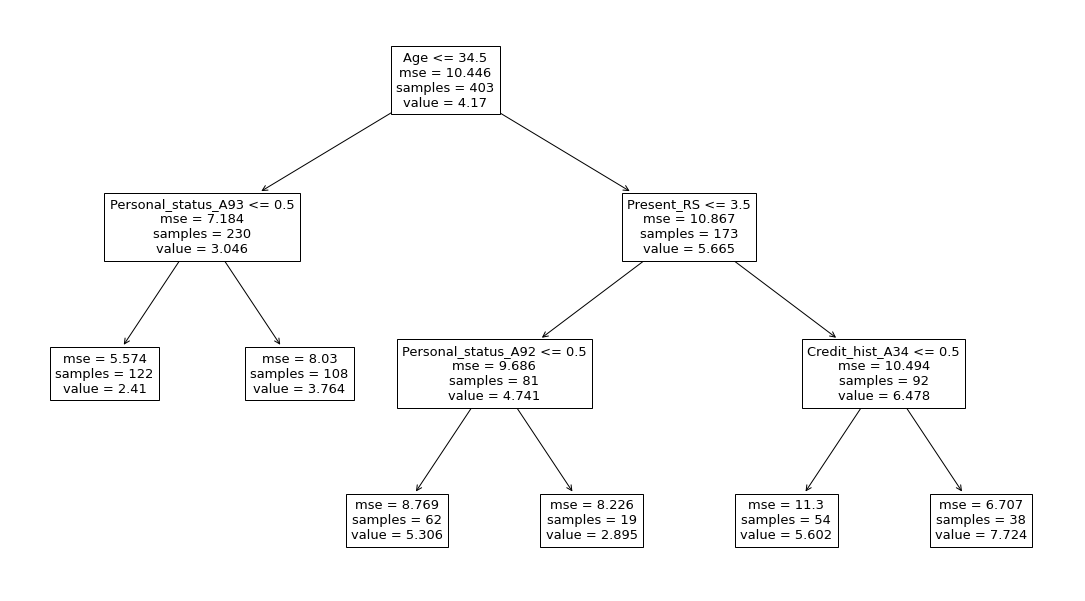

MSE LinearRegression with all features 10.849046503004898


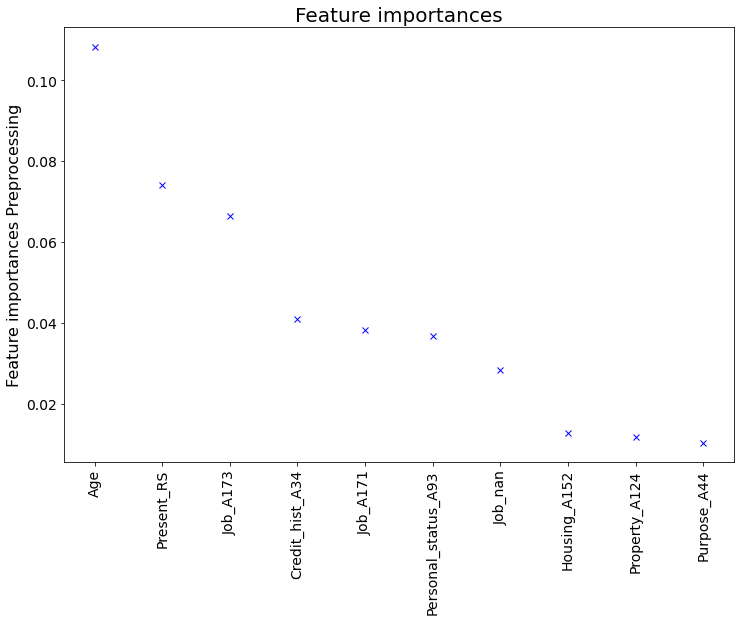

MSE of Linear Regression model with highest feature importances 9.112845912668554
Shape of X_train with all features (403, 59)
Shape of X_train with best features only (496, 15)
Linear Regression with most important features was used


In [552]:
#Predict Present ES with 1st type of preprocessed dataset
data1 = predictPresentES(preprocessedData1)

Best parameters of DecisionTreeRegressor {'max_leaf_nodes': 6, 'min_samples_split': 48}
MSE DecisionTreeRegressor 10.20831722843932


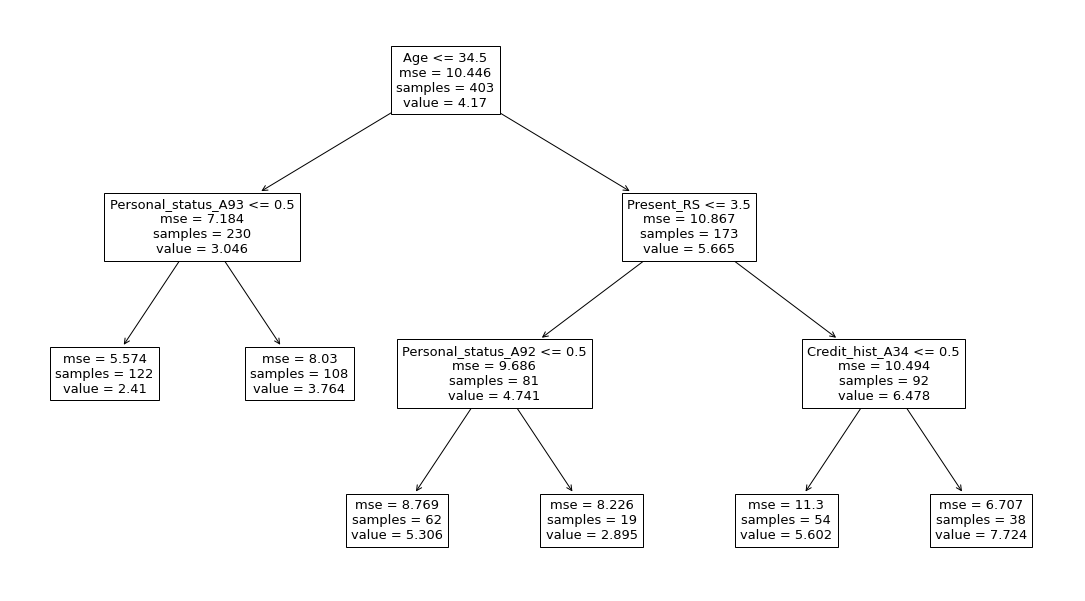

MSE LinearRegression with all features 10.944492752528477


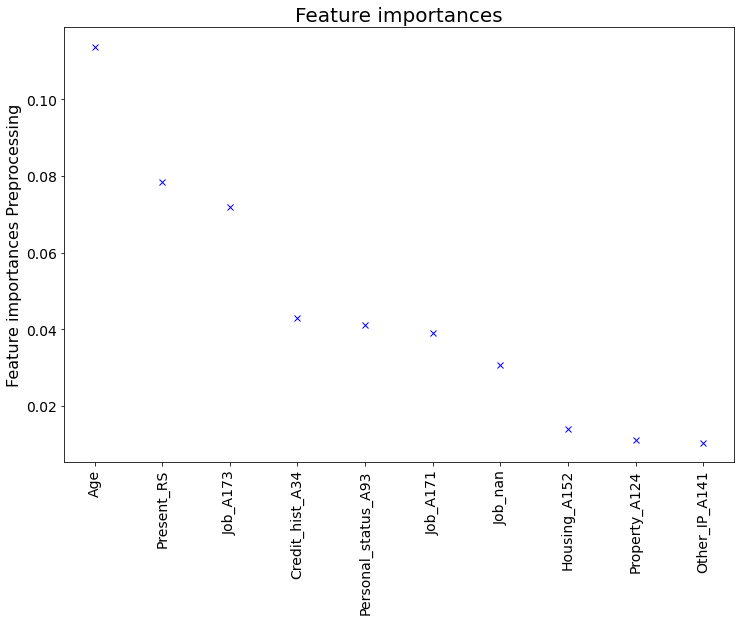

MSE of Linear Regression model with highest feature importances 9.279687673121465
Shape of X_train with all features (403, 52)
Shape of X_train with best features only (496, 13)
Linear Regression with most important features was used


In [553]:
#Predict Present ES with 2nd type of preprocessed dataset
data2 = predictPresentES(preprocessedData2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


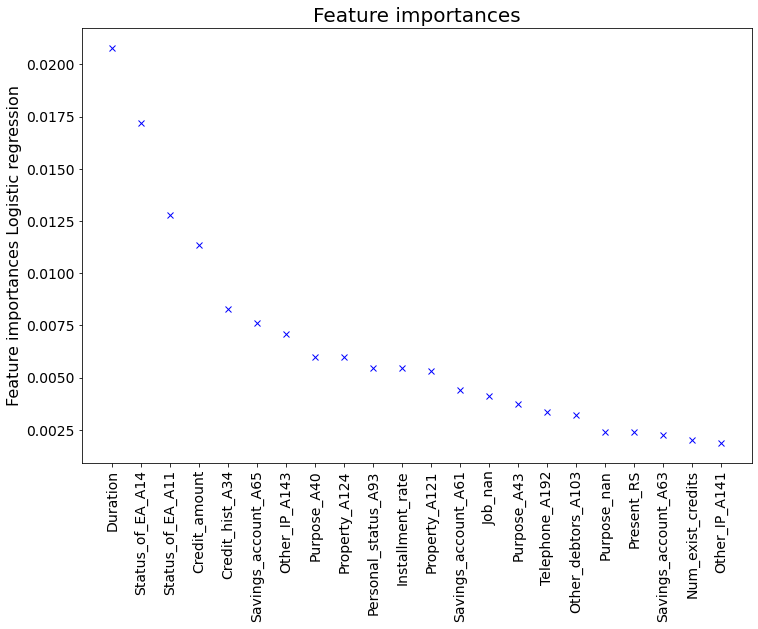

Shape of X_train with all features (750, 60)
Shape of X_train with most important features (750, 22)


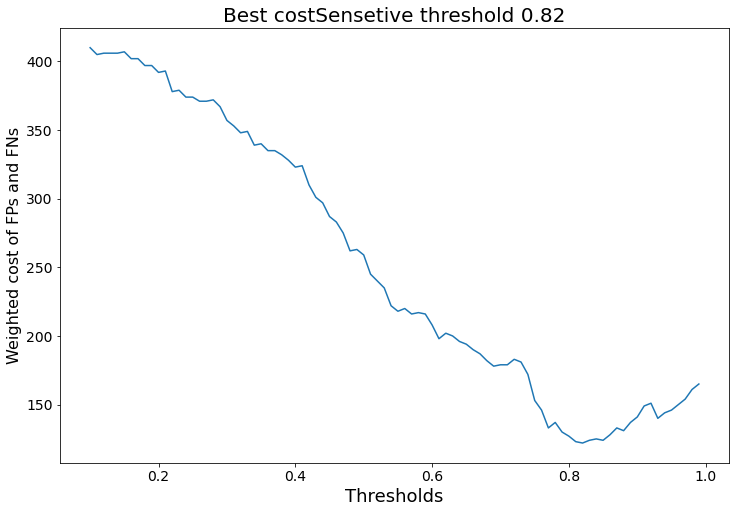

In [554]:
#Use logistic regression model with 1st type preprocessed dataset using most important features
model_T1_Best, y_proba_T1_Best, y_pred_T1_Best, metricsDefault_T1_Best, metricsDiffThr_T1_Best, y_test_T1_Best = analyseAllPreprocTypes(data1, labels, True)                                                                                                            

In [555]:
metricsDefault_T1_Best

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with threshold,Threshold,F1 score
0,Logistic Regression Default param,0.75,0.854545,47,24,141,38,0.716,259,0.5,0.798867


In [556]:
metricsDiffThr_T1_Best

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with current threshold,Threshold,F1 score,Weighted F1 score
0,Logistic Regression,0.809524,0.618182,24,63,61,61,0.652,183,0.72,0.701031,0.527132
0,Logistic Regression,0.811475,0.600000,23,66,62,62,0.644,181,0.73,0.689895,0.522427
0,Logistic Regression,0.823529,0.593939,21,67,64,64,0.648,172,0.74,0.690141,0.532609
0,Logistic Regression,0.850877,0.587879,17,68,68,68,0.660,153,0.75,0.695341,0.559078
0,Logistic Regression,0.862385,0.569697,15,71,70,70,0.656,146,0.76,0.686131,0.562874
0,Logistic Regression,0.884615,0.557576,12,73,73,73,0.660,133,0.77,0.684015,0.580442
0,Logistic Regression,0.880000,0.533333,12,77,73,73,0.644,137,0.78,0.664151,0.562300
0,Logistic Regression,0.894737,0.515152,10,80,75,75,0.640,130,0.79,0.653846,0.566667
0,Logistic Regression,0.902174,0.503030,9,82,76,76,0.636,127,0.80,0.645914,0.566553
0,Logistic Regression,0.911111,0.496970,8,83,77,77,0.636,123,0.81,0.643137,0.571429


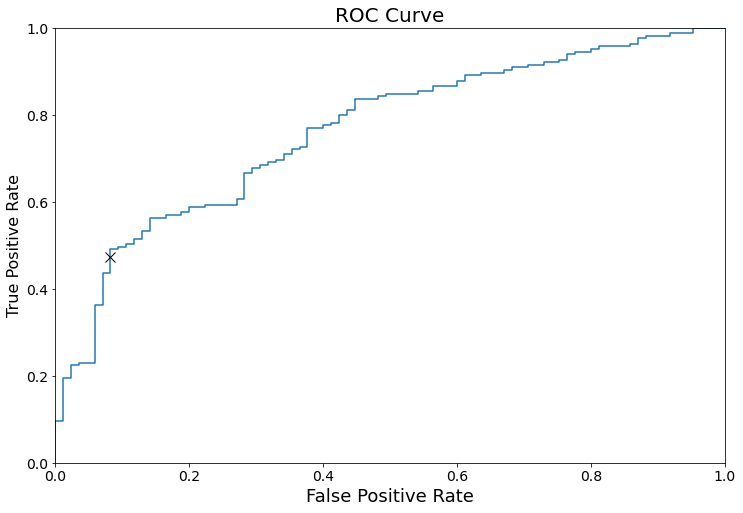

In [557]:
printROCcurve(y_test_T1_Best, y_proba_T1_Best, y_pred_T1_Best, metricsDiffThr_T1_Best)

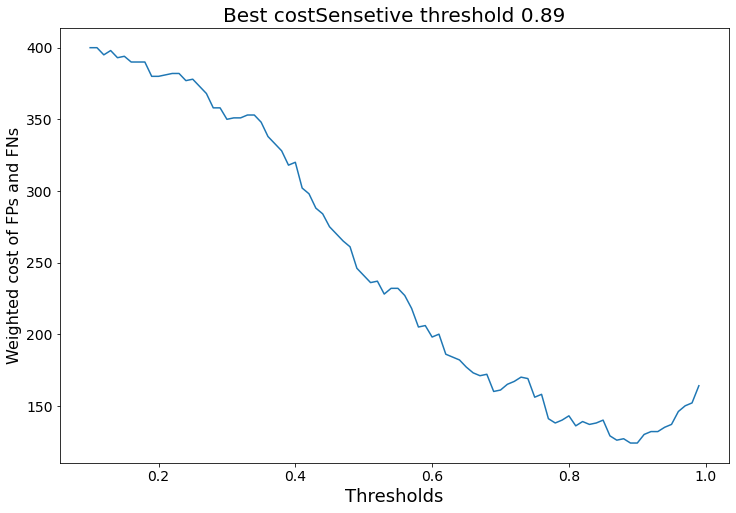

In [558]:
#Use logistic regression model with 1st type preprocessed dataset using all features
model_T1_ALL, y_proba_T1_ALL, y_pred_T1_ALL, metricsDefault_T1_ALL, metricsDiffThr_T1_ALL, y_test_T1_ALL = analyseAllPreprocTypes(data1, labels, False)

In [559]:
metricsDefault_T1_ALL

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with threshold,Threshold,F1 score
0,Logistic Regression Default param,0.765957,0.872727,44,21,144,41,0.74,241,0.5,0.815864


In [560]:
metricsDiffThr_T1_ALL

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with current threshold,Threshold,F1 score,Weighted F1 score
0,Logistic Regression,0.873786,0.545455,13,75,72,72,0.648,140,0.79,0.671642,0.562500
0,Logistic Regression,0.870000,0.527273,13,78,72,72,0.636,143,0.80,0.656604,0.548896
0,Logistic Regression,0.887640,0.478788,10,86,75,75,0.616,136,0.81,0.622047,0.537415
0,Logistic Regression,0.883721,0.460606,10,89,75,75,0.604,139,0.82,0.605578,0.522337
0,Logistic Regression,0.890244,0.442424,9,92,76,76,0.596,137,0.83,0.591093,0.515901
0,Logistic Regression,0.888889,0.436364,9,93,76,76,0.592,138,0.84,0.585366,0.510638
0,Logistic Regression,0.886076,0.424242,9,95,76,76,0.584,140,0.85,0.573770,0.500000
0,Logistic Regression,0.916667,0.400000,6,99,79,79,0.580,129,0.86,0.556962,0.505747
0,Logistic Regression,0.927536,0.387879,5,101,80,80,0.576,126,0.87,0.547009,0.503937
0,Logistic Regression,0.926471,0.381818,5,102,80,80,0.572,127,0.88,0.540773,0.498024


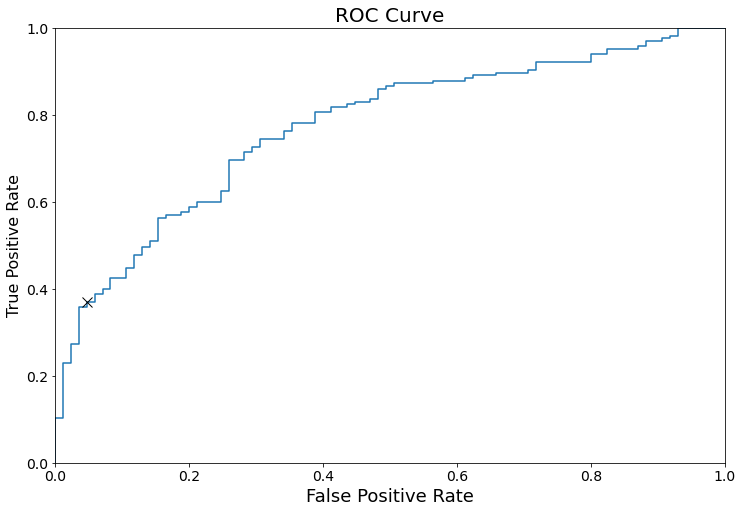

In [561]:
printROCcurve(y_test_T1_ALL, y_proba_T1_ALL, y_pred_T1_ALL, metricsDiffThr_T1_ALL)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


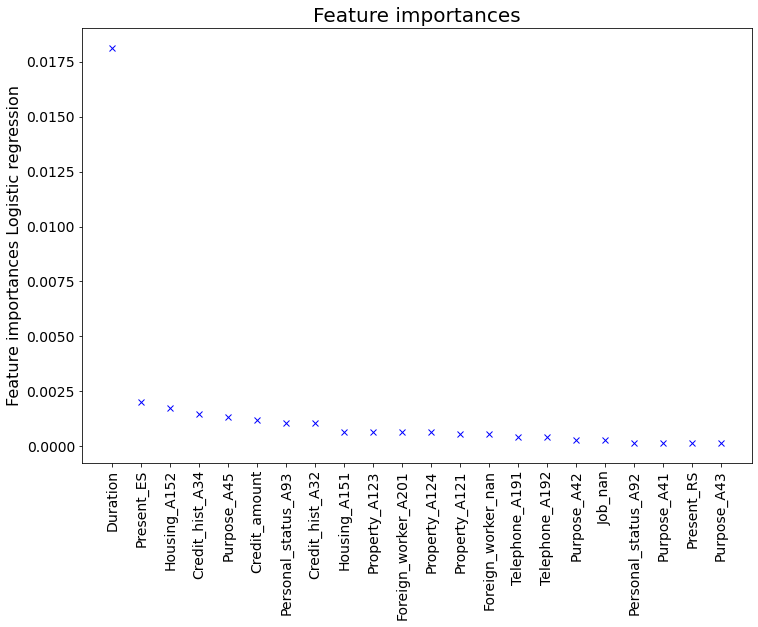

Shape of X_train with all features (750, 53)
Shape of X_train with most important features (750, 3)


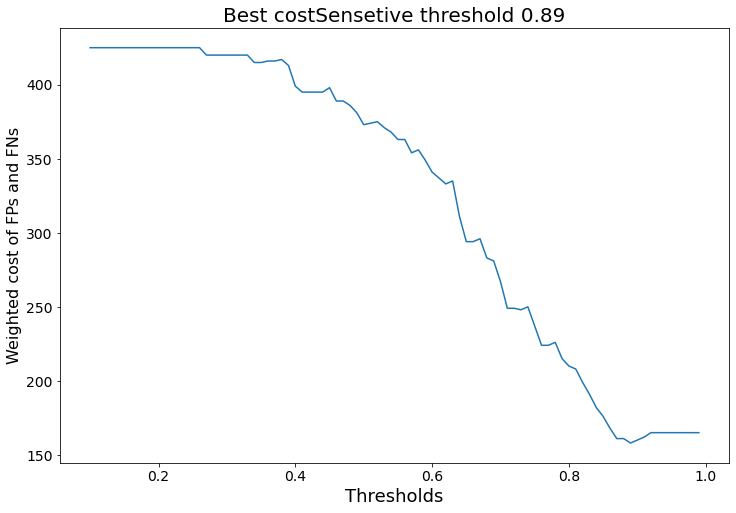

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [562]:
#Use logistic regression model with 2nd type preprocessed dataset using most important features
model_T2_Best, y_proba_T2_Best, y_pred_T2_Best, metricsDefault_T2_Best, metricsDiffThr_T2_Best, y_test_T2_Best = analyseAllPreprocTypes(data2, labels, True)  

In [563]:
metricsDefault_T2_Best

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with threshold,Threshold,F1 score
0,Logistic Regression Default param,0.678571,0.921212,72,13,152,13,0.66,373,0.5,0.781491


In [564]:
metricsDiffThr_T2_Best

,Estimator,Precision,Recall,Number FP,Number FN,Number TP,Number TN,Accuracy,Total cost with current threshold,Threshold,F1 score,Weighted F1 score
0,Logistic Regression,0.738636,0.393939,23,100,62,62,0.508,215,0.79,0.513834,0.376812
0,Logistic Regression,0.733333,0.333333,20,110,65,65,0.480,210,0.80,0.458333,0.343750
0,Logistic Regression,0.723077,0.284848,18,118,67,67,0.456,208,0.81,0.408696,0.311258
0,Logistic Regression,0.732143,0.248485,15,124,70,70,0.444,199,0.82,0.371041,0.291815
0,Logistic Regression,0.750000,0.236364,13,126,72,72,0.444,191,0.83,0.359447,0.289963
0,Logistic Regression,0.767442,0.200000,10,132,75,75,0.432,182,0.84,0.317308,0.266129
0,Logistic Regression,0.774194,0.145455,7,141,78,78,0.408,176,0.85,0.244898,0.214286
0,Logistic Regression,0.814815,0.133333,5,143,80,80,0.408,168,0.86,0.229167,0.207547
0,Logistic Regression,0.863636,0.115152,3,146,82,82,0.404,161,0.87,0.203209,0.190955
0,Logistic Regression,0.875000,0.084848,2,151,83,83,0.388,161,0.88,0.154696,0.148148


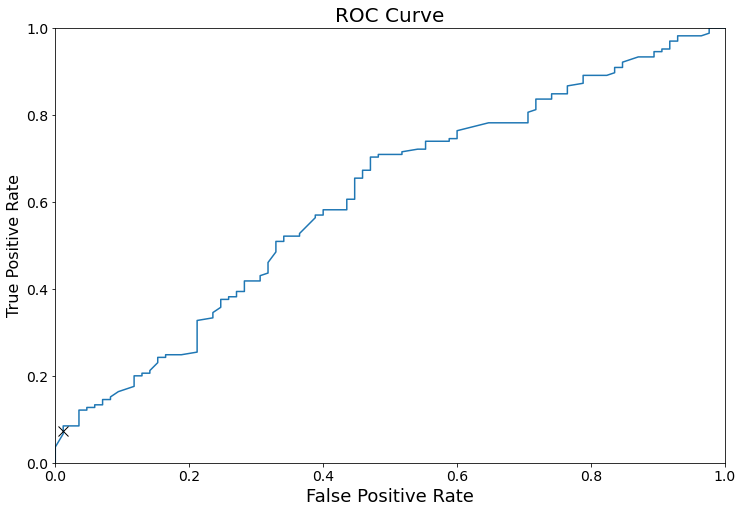

In [565]:
printROCcurve(y_test_T2_Best, y_proba_T2_Best, y_pred_T2_Best, metricsDiffThr_T2_Best)